# Download data and feature extension

In [1]:
# import pandas as pd
# from mylibs.jingyi_shen_paper import get_data_jingyi_shen, feature_extension

In [2]:
# stock_list = ['600519.SH', '000858.SZ', '000596.SZ', '000568.SZ', '600779.SH', '600809.SH', '002304.SZ']

In [3]:
# data_origin = get_data_jingyi_shen(stock_list, start_date='20140101', end_date='20211231')

In [4]:
'''
data should contain three parts of column:
ts_code and trade_date to search
all features to train
ohlc for backtesting
''';
# data = feature_extension(data_origin, stock_list)

In [5]:
# data.to_csv(f'./data/jingyi_shen/data.csv', sep=',', index=False)

# One run

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from mylibs.jingyi_shen_paper import rfe_selection_with_all_stocks, do_pca
from mylibs.training_part import generate_sequence, create_model, class_weight
from mylibs.training_part import plot_process, evaluate, my_callback, one_run_inner, print_basic_info
%load_ext tensorboard

### Recursive feature elimination

In [7]:
stock_list = ['600519.SH', '000858.SZ', '000596.SZ', '000568.SZ', '600779.SH', '600809.SH', '002304.SZ']

In [8]:
data = pd.read_csv(f'./data/jingyi_shen/data.csv')

In [9]:
'''
n_features_to_select is not for the whole function rfe_selection_with_all_stocks
but for an inside function rfe_selection
therefore, to get a certain number of selected features, you can only manully adjust n_features_to_select
unfortunately, the number you want may never show up
'''
n_features_to_select = 39
final_selected_features = rfe_selection_with_all_stocks(stock_list, data, n_features_to_select)

32 features are selected


### Pre-processing and Principle component analysis

### Control panel

In [10]:
ts_code = '000858.SZ'
split = 0.1
validation_split = 0.2
label_threshold = 0.005
lookback = 15
hu = 256
layers = 1
learning_rate = 0.0001
batch_size = 64
start = '2016'
end = '2022'
activation_function = 'relu'

In [11]:
'''target_data is a dataframe that fianlly fed into the ML model'''
'''pick out the data of target stock'''
target_data = data[data['ts_code'] == ts_code].set_index('trade_date').drop('ts_code', axis=1).sort_index().copy()
'''
target_data should contain three necessary clomuns: label, ret
ret and close are for functional purpose and are not necessarily in the features
'''
target_data = target_data[final_selected_features + ['ret', 'label']]
target_data = target_data[start:end]

In [12]:
"""only use training dataset to do PCA"""
X = target_data.drop(['label', 'ret'], axis=1)
y = target_data[['ret', 'label']].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split, shuffle=False)

In [13]:
'''I store back_test_data to a csv file for backtesting in another ipynb'''
'''only need the trade_date in X_test'''
back_test_data = X_test[lookback - 1:].reset_index().copy()[['trade_date']]
'''use the trade_date in X_test to pick out ohlc and volume for backtesting'''
df_aux = data[data['ts_code'] == ts_code][['trade_date', 'open', 'high', 'low', 'close', 'vol']]
back_test_data = pd.merge(back_test_data, df_aux, how='left', on='trade_date')

In [14]:
'''do_pca scales data with standard scaler then conducts PCA'''
X_train, X_test = do_pca(20, X_train, X_test)

0.9957595464569223


### Model

In [15]:
X_train, y_train = generate_sequence(X_train, y_train, lookback)
X_test, y_test = generate_sequence(X_test, y_test, lookback)

------------------------------------------------------------ basic info ------------------------------------------------------------
number of training sample: 1020
number of testing sample: 132
------------------------------------------------------------ model summary ------------------------------------------------------------
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM1 (LSTM)                 (None, 256)               283648    
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
Output (Dense)               (None, 1)                 257       
Total params: 283,905
Trainable params: 283,905
Non-tra

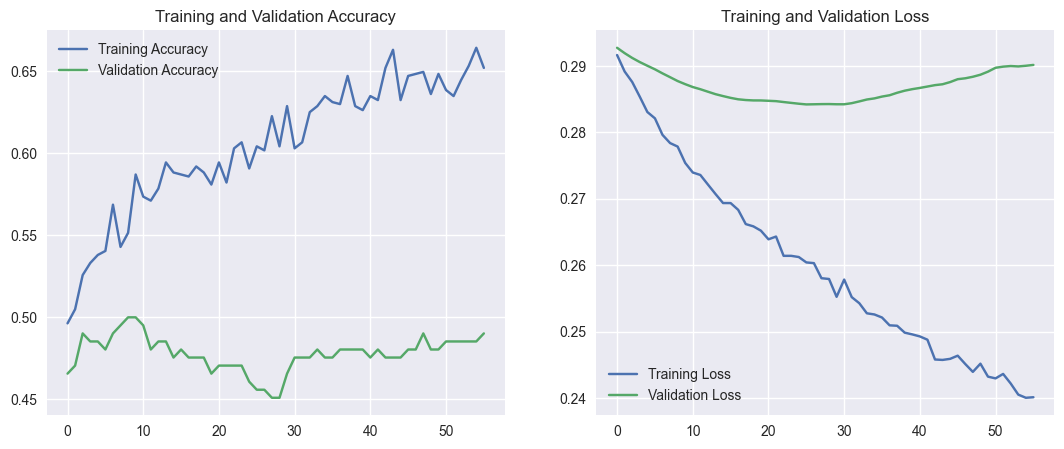

------------------------------------------------------------ test data ------------------------------------------------------------


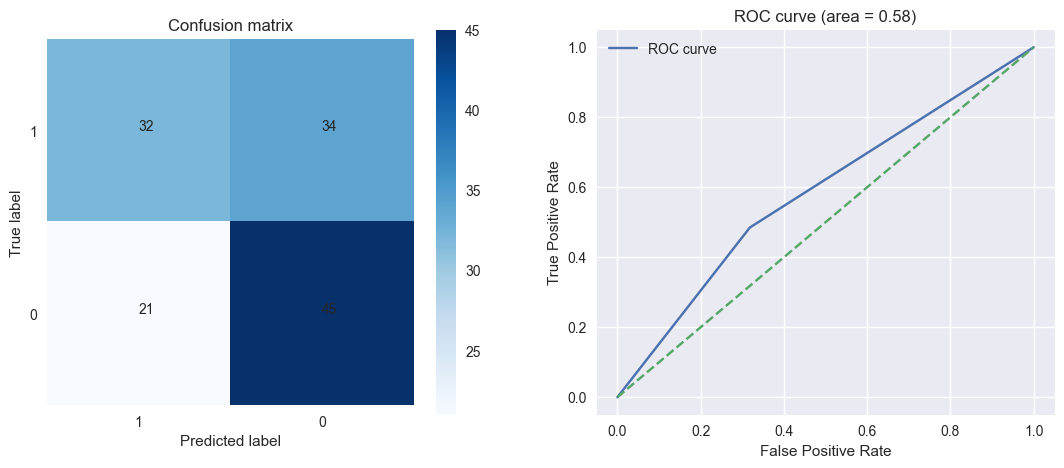

loss:  0.26443564891815186
accuracy:  0.5833333134651184
TP:  32    FP:  21    TN:  45    FN:  34
precision:  0.6037724457123665
recall:  0.48484775023068144
f1:  0.5377648234059774
CPU times: total: 8.67 s
Wall time: 10.2 s


In [16]:
%%time
'''the only purpose of file_name here is for the path name of tensorboard'''
file_name = 'jingyi_shen'
y_pred = one_run_inner(X_train, X_test, y_train, y_test, file_name, label_threshold, hu, layers,
                       learning_rate, activation_function, batch_size, validation_split)

In [17]:
'''prepare data for backtesting'''
back_test_data['probability'] = y_pred
back_test_data.to_csv(f'./data/jingyi_shen/back_test.csv', sep=',', index=False)